In [1]:
%matplotlib inline

In [2]:
import pddp
import pddp.examples

In [3]:
import torch

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_variance(Z, encoding, indices=None, std_scale=1.0):
    mean_ = pddp.utils.encoding.decode_mean(Z, encoding)
    std_ = pddp.utils.encoding.decode_std(Z, encoding)
        
    if indices is None:
        indices = list(range(mean_.shape[-1]))

    plt.figure(figsize=(12, 6))
    plt.xlabel("Time steps")
    t = torch.arange(Z.shape[0]).detach().numpy()
    for index in indices:
        mean = mean_[:, index].detach().numpy()
        std = std_[:, index].detach().numpy()

        _ = plt.plot(t, mean, label="Mean estimate")

        for i in range(1, 4):
            j = std_scale * i
            _ = plt.gca().fill_between(
                t.flat, (mean - j * std).flat, (mean + j * std).flat,
                color="#dddddd", alpha=1.0/i, label="Confidence")
            
    plt.ylim(-5, 5)

    plt.show()

In [6]:
def plot_particles(Xs, indices=None, title="Dynamics rollout"):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    if indices is None:
        indices = list(range(Xs.shape[-1]))

    t = torch.arange(Xs.shape[1]).detach().numpy()
    for index in indices:
        for particle in Xs:
            X = particle[:, index].detach().numpy()
            _ = plt.plot(t, X, color="b", alpha=0.05)

    plt.ylim(-5,5)
            
    plt.show()

In [7]:
N = 25  # Horizon length.
DT = 0.1  # Time step (s).
RENDER = False  # Whether to render the environment or not.
ENCODING = pddp.StateEncoding.DEFAULT

In [8]:
torch.set_default_dtype(torch.float64)

In [9]:
cost = pddp.examples.cartpole.CartpoleCost().double()
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)
true_model = pddp.examples.cartpole.CartpoleDynamicsModel(DT).double()

In [10]:
controller = pddp.controllers.iLQRController(env, true_model, cost).double()

In [11]:
U = torch.randn(N, env.action_size).double()

In [12]:
Z, U = controller.fit(U, encoding=pddp.StateEncoding.IGNORE_UNCERTAINTY, n_iterations=10, tol=1e-2)

In [13]:
model = pddp.models.bnn.bnn_dynamics_model_factory(
    env.state_size, env.action_size, [200, 200], true_model.angular_indices, true_model.non_angular_indices,
    dropout_layers=pddp.models.bnn.CDropout,
)(n_particles=1000).double()

In [14]:
dataset, _, _ = pddp.controllers.pddp._train(env, model, cost, U, 1, training_opts={"normalize": True})

In [15]:
z0 = dataset[0][0]
z0 = torch.cat([z0, torch.zeros(10)])
# z0 = pddp.utils.encoding.encode(z0, C=torch.eye(4)*0).requires_grad_()
u = U[0].requires_grad_()

In [16]:
Z = torch.empty(N + 1, z0.shape[0])
Z[0] = z0

for i, u in enumerate(U):
    Z[i + 1] = model(Z[i], u, i, encoding=ENCODING, use_L=True)

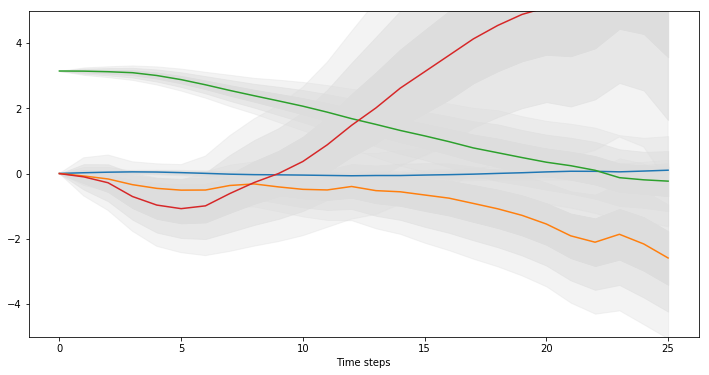

In [17]:
plot_variance(Z, ENCODING)

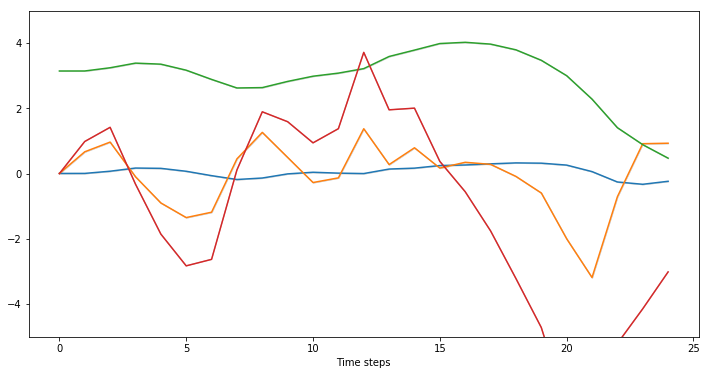

In [18]:
plot_variance(dataset[0], 4, std_scale=0)

In [19]:
DX = {}
INPUTS = {}
Ls = {}

def particles_model(z, u, i):
    mean = z.mean(0)
    std = z.std(0)
    # z = pddp.utils.encoding.encode(mean, S=std, encoding=ENCODING)
    # mean = pddp.utils.encoding.decode_mean(z, encoding=ENCODING)
    # std = pddp.utils.encoding.decode_std(z, encoding=ENCODING)

    deltas = z - mean
    C = deltas.t().mm(deltas) / (z.shape[0] - 1)
    L = C if C.allclose(torch.zeros_like(C)) else C.potrf()
    Ls[i] = L
    
    # x = mean + model.eps1[i].mm(L)
    x = z

    INPUTS[i] = x
    x_ = pddp.utils.angular.augment_state(x, true_model.angular_indices, true_model.non_angular_indices)
    x_ = torch.cat([x_, u], dim=-1)
    
    x_ = model._normalize_input(x_)
    out = model.model(x_)
    dx, log_std = out.split([mean.shape[-1], mean.shape[-1]], -1)
    dx, log_std = model._scale_output(dx, log_std)
    DX[i] = dx

    return x + dx

In [20]:
n_particles = 1000
P = torch.empty(n_particles, N + 1, 4)
P[:, 0, :] = z0[:4].repeat(n_particles, 1).double()

for i, u in enumerate(U):
    p = P[:, i, :]
    u = u.repeat(n_particles, 1)
    P[:, i+1, :] = particles_model(p, u, i)

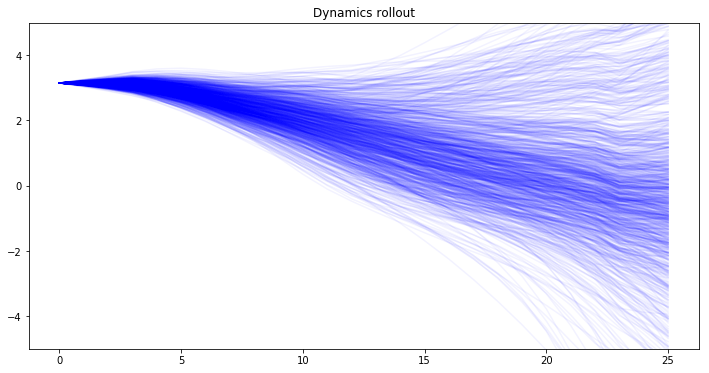

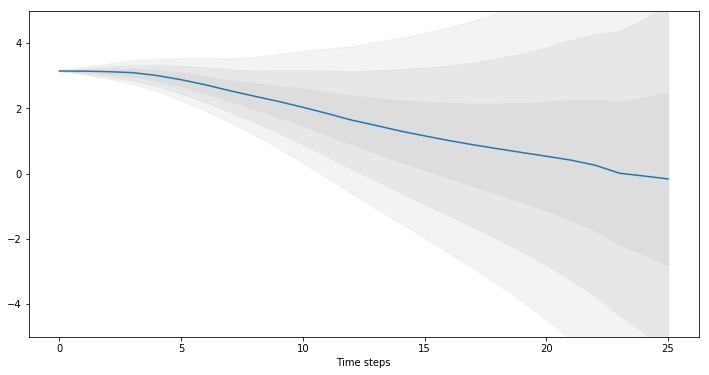

In [21]:
M = P.mean(0)
S = P.std(0)
S[0] += 1e-9
Z__ = pddp.utils.encoding.encode(M, S=S, encoding=ENCODING)
plot_particles(P, [2])
plot_variance(Z__, ENCODING, [2])

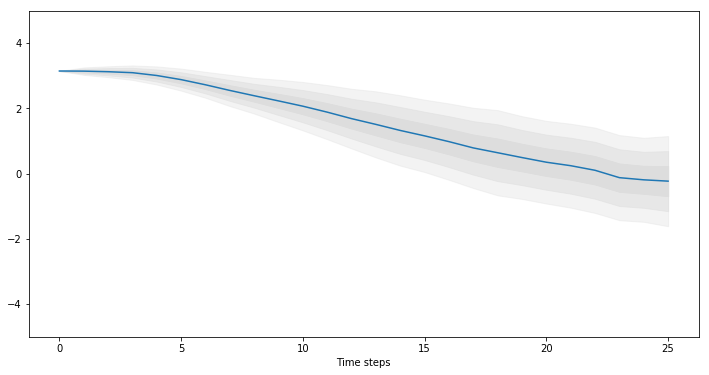

In [22]:
plot_variance(Z, ENCODING, [2])

In [23]:
P.var(0)

tensor([[  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0001,   0.0087,   0.0014,   0.0381],
        [  0.0005,   0.0296,   0.0059,   0.1481],
        [  0.0011,   0.0581,   0.0144,   0.3317],
        [  0.0020,   0.0924,   0.0274,   0.5629],
        [  0.0030,   0.1331,   0.0459,   0.8246],
        [  0.0040,   0.1839,   0.0717,   1.1316],
        [  0.0051,   0.2558,   0.1058,   1.5607],
        [  0.0060,   0.3443,   0.1563,   2.0801],
        [  0.0071,   0.4610,   0.2304,   2.6748],
        [  0.0085,   0.6247,   0.3244,   3.4709],
        [  0.0102,   0.8483,   0.4361,   4.5181],
        [  0.0124,   1.1559,   0.5603,   5.8543],
        [  0.0156,   1.5340,   0.7208,   7.1885],
        [  0.0197,   2.0369,   0.8915,   8.8201],
        [  0.0253,   2.6529,   1.0955,  10.6383],
        [  0.0323,   3.4229,   1.3239,  12.9373],
        [  0.0414,   4.3623,   1.5948,  15.8483],
        [  0.0531,   5.5132,   1.9184,  19.6407],
        [  0.0676,   6.9336,   2.3039,  24.6797],


In [24]:
pddp.utils.encoding.decode_var(Z, ENCODING)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0001, 0.0087, 0.0014, 0.0381],
        [0.0003, 0.0153, 0.0031, 0.0804],
        [0.0004, 0.0208, 0.0055, 0.1260],
        [0.0006, 0.0242, 0.0086, 0.1778],
        [0.0008, 0.0310, 0.0127, 0.2025],
        [0.0009, 0.0375, 0.0176, 0.2588],
        [0.0012, 0.0456, 0.0256, 0.3496],
        [0.0014, 0.0537, 0.0334, 0.4232],
        [0.0015, 0.0623, 0.0469, 0.4841],
        [0.0017, 0.0768, 0.0613, 0.5760],
        [0.0018, 0.0941, 0.0765, 0.7121],
        [0.0020, 0.1191, 0.0931, 0.9191],
        [0.0022, 0.1485, 0.1142, 1.1852],
        [0.0025, 0.1853, 0.1293, 1.4038],
        [0.0030, 0.2379, 0.1367, 1.6283],
        [0.0036, 0.2830, 0.1525, 1.8455],
        [0.0041, 0.3193, 0.1682, 1.8529],
        [0.0050, 0.3464, 0.1898, 1.9710],
        [0.0062, 0.3780, 0.1788, 2.0653],
        [0.0062, 0.4062, 0.1785, 2.1067],
        [0.0075, 0.4665, 0.1840, 2.3754],
        [0.0077, 0.5335, 0.1902, 2.4446],
        [0.0075, 0.6044, 0.1890, 2